In [5]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [32]:

import pandas as pd
import numpy as np
import random 
from sklearn.preprocessing import LabelEncoder
import optuna
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

CSV_PATH="/home/ivan/Desktop/Diplomska/final_results_csv/cleaned_songs_with_perplexity.csv"
df=pd.read_csv(CSV_PATH)
random_seed=47

In [ ]:
import tensorflow as tf
from tensorflow import keras
import joblib
import numpy as np


model = keras.models.load_model("dual_model.keras")
vectorizer = joblib.load("vectorizer.pkl")
label_encoder = joblib.load("label_encoder.pkl")

def evaluate_song(song_text):
    song_text = song_text.lower()
    X = vectorizer.transform([song_text]).toarray()

    author_pred, gen_pred = model.predict(X, verbose=0)
    predicted_author = label_encoder.inverse_transform([np.argmax(author_pred)])[0]
    is_generated = (gen_pred[0][0] > 0.5)

    authenticity = "Generated" if is_generated else "Authentic"

    print(f"\nPredicted Author: {predicted_author}")
    print(f"Authenticity: {authenticity} ({gen_pred[0][0]:.3f} confidence)")

    return predicted_author, authenticity


test_song = """Сенка на минатото


Беше таа, меѓу сите, нејзината сенка што се вткаа
во денови што се втиснаа во сеќавање.
Првата, пред погледите, оти нејзината моќ
ја привлекуваше погледите на сите.

Мојата душа, во тага, се губи во времето,
во мигови што оставија траги на нејзиното лице.
Нејзината култура, нејзината убавина, нејзината привлечност -
сè тоа сега е само сенка на минатото.

Животот, кој некогаш беше толку жив,
сега е само тага, само жал за изгубеното.
Очите, што некогаш гледаа во иднината,
сега се затворени пред реалноста на смртта.

Но, во таа сенка, во тоа минато,
сè уште постои искра на надеж,
искра што ветува дека времето ќе го врати
она што некогаш беше, и што повторно ќе биде.

"""
evaluate_song(test_song)



Predicted Author: Братислав Ташковски
Authenticity: Authentic (0.003 confidence)


('Братислав Ташковски', 'Authentic')

All songs being used with high creativity of the models

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import matplotlib.pyplot as plt
import seaborn as sns

def limit_per_author(df, max_per_author=10):
    return df.groupby("author", group_keys=False).apply(
        lambda x: x.sample(n=min(len(x), max_per_author), random_state=42)
    )

def train_dual_output_model(
    train_csv_path,
    eval_csv_path,
    max_per_author=300,
    min_author_samples=10,
    best_params=None,
    test_size=0.2,
    batch_size=32,
    verbose=0
):
    if best_params is None:
        best_params = {
            'max_features': 4619,
            'n_layers': 1,
            'neurons': 567,
            'activation': 'tanh',
            'dropout_rate': 0.3406819279083615,
            'optimizer': 'rmsprop',
            'lr': 0.0007878787378953067,
            'l2_reg': 3.145848564707723e-05,
            'n_epochs': 41,
            'min_df': 3,
            'max_df': 0.8904674508605334,
            'ngram_range': (1, 1)
        }

    
    df_authentic = pd.read_csv(train_csv_path)
    df_authentic['song_text'] = df_authentic['song_text'].str.lower()
    df_authentic['is_generated'] = 0  

    
    df_generated = pd.read_csv(eval_csv_path)
    df_generated['new_song'] = df_generated['new_song'].str.lower()
    df_generated.rename(columns={'new_song': 'song_text'}, inplace=True)
    df_generated['is_generated'] = 1  

    
    df_authentic_limited = limit_per_author(df_authentic, max_per_author)
    df_generated_limited = limit_per_author(df_generated, max_per_author)

    print(f"Authentic songs after limiting: {len(df_authentic_limited)}")
    print(f"Generated songs after limiting: {len(df_generated_limited)}")

    df_all = pd.concat([
        df_authentic_limited[['song_text', 'author', 'is_generated']],
        df_generated_limited[['song_text', 'author', 'is_generated']]
    ], ignore_index=True)
    print(f"Combined dataset size: {len(df_all)}")

    author_counts = df_all['author'].value_counts()
    valid_authors = author_counts[author_counts >= min_author_samples].index
    df_all = df_all[df_all['author'].isin(valid_authors)]
    print(f"Dataset size after filtering authors with <{min_author_samples} samples: {len(df_all)}")
    print(f"Remaining authors: {len(valid_authors)}")

    vectorizer = TfidfVectorizer(
        max_features=best_params['max_features'],
        ngram_range=best_params['ngram_range'],
        min_df=best_params['min_df'],
        max_df=best_params['max_df']
    )
    X = vectorizer.fit_transform(df_all['song_text']).toarray()

    label_encoder = LabelEncoder()
    y_author = label_encoder.fit_transform(df_all['author'])
    y_generated = df_all['is_generated'].values

    X_train, X_test, y_auth_train, y_auth_test, y_gen_train, y_gen_test = train_test_split(
        X, y_author, y_generated, test_size=test_size, random_state=42, stratify=y_author
    )

    input_layer = layers.Input(shape=(X_train.shape[1],))
    x = input_layer
    for i in range(best_params['n_layers']):
        x = layers.Dense(
            best_params['neurons'],
            activation=best_params['activation'],
            kernel_regularizer=regularizers.l2(best_params['l2_reg'])
        )(x)
        x = layers.Dropout(best_params['dropout_rate'])(x)

    author_output = layers.Dense(len(label_encoder.classes_), activation="softmax", name="author_output")(x)
    generated_output = layers.Dense(1, activation="sigmoid", name="generated_output")(x)

    model = keras.Model(inputs=input_layer, outputs=[author_output, generated_output])

    optimizer = keras.optimizers.RMSprop(learning_rate=best_params['lr'])
    model.compile(
        optimizer=optimizer,
        loss={
            "author_output": "sparse_categorical_crossentropy",
            "generated_output": "binary_crossentropy"
        },
        metrics={
            "author_output": "accuracy",
            "generated_output": "accuracy"
        }
    )

    history = model.fit(
        X_train,
        {"author_output": y_auth_train, "generated_output": y_gen_train},
        validation_split=0.1,
        epochs=best_params['n_epochs'],
        batch_size=batch_size,
        verbose=verbose
    )

    pred_auth, pred_gen = model.predict(X_test, verbose=0)
    y_auth_pred = np.argmax(pred_auth, axis=1)
    y_gen_pred = (pred_gen > 0.5).astype(int).flatten()

    print("\n=== Generated vs Authentic Classification ===")
    print(classification_report(y_gen_test, y_gen_pred, target_names=["Authentic", "Generated"], zero_division=0))

    print("\n=== Author Prediction ===")
    print(classification_report(y_auth_test, y_auth_pred, target_names=label_encoder.classes_, zero_division=0))

    f1_author = f1_score(y_auth_test, y_auth_pred, average="weighted")
    f1_gen = f1_score(y_gen_test, y_gen_pred, average="weighted")
    print(f"\nWeighted F1 - Author: {f1_author:.4f}, Generated/Authentic: {f1_gen:.4f}")

   
    cm_gen = tf.math.confusion_matrix(y_gen_test, y_gen_pred).numpy()
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm_gen, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Authentic", "Generated"], yticklabels=["Authentic", "Generated"])
    plt.title('Generated vs Authentic Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    
    cm_auth = tf.math.confusion_matrix(y_auth_test, y_auth_pred).numpy()
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_auth, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title('Author Prediction Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return model, history, label_encoder, vectorizer

Authentic songs after limiting: 1199
Generated songs after limiting: 1199
Combined dataset size: 2398
Dataset size after filtering authors with <3 samples: 2388
Remaining authors: 32

=== Generated vs Authentic Classification ===
              precision    recall  f1-score   support

   Authentic       0.97      0.99      0.98       226
   Generated       0.99      0.98      0.98       252

    accuracy                           0.98       478
   macro avg       0.98      0.98      0.98       478
weighted avg       0.98      0.98      0.98       478


=== Author Prediction ===
                      precision    recall  f1-score   support

         Јосип Коцев       1.00      0.50      0.67         2
        Адам Гајтани       0.76      0.68      0.72        19
       Анте Поповски       1.00      0.75      0.86         8
       Ацо Караманов       0.00      0.00      0.00         2
           Ацо Шопов       0.88      0.58      0.70        12
       Блаже Конески       0.61      0.89  

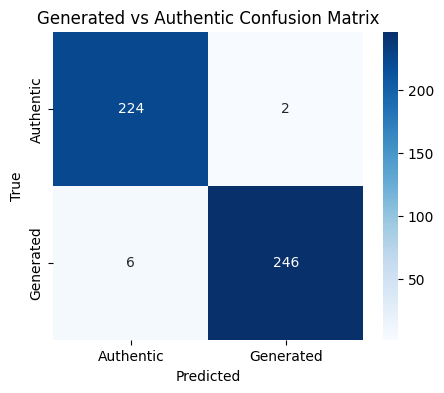

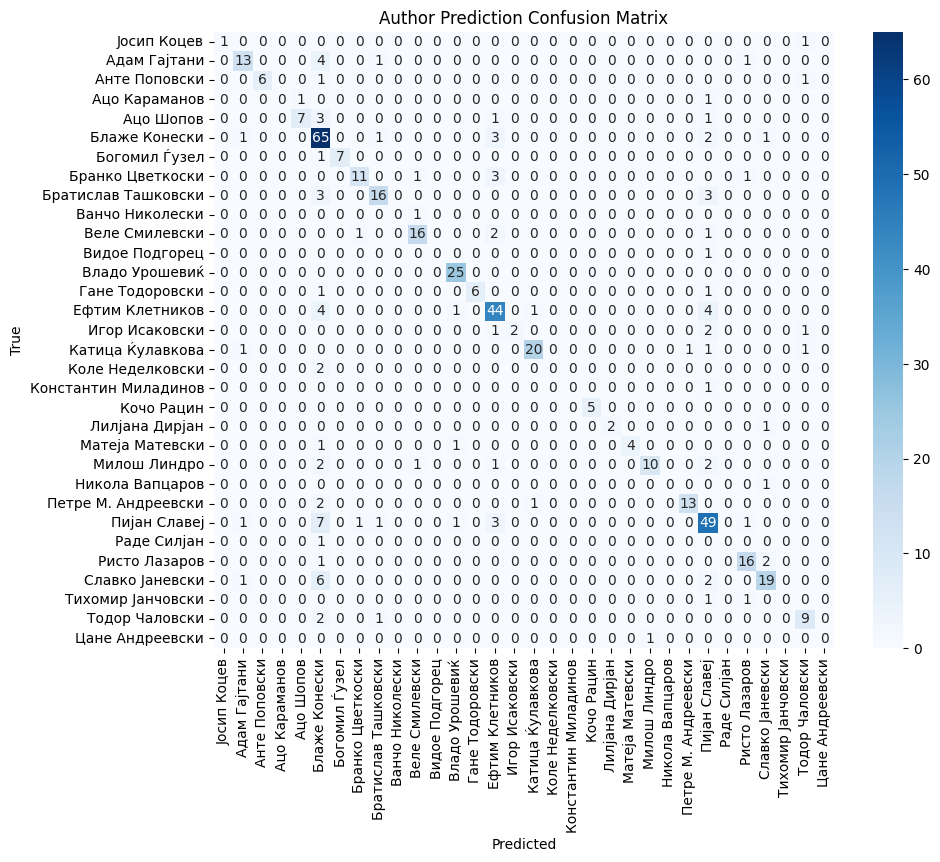

(<Functional name=functional_13, built=True>,
 LabelEncoder(),
 TfidfVectorizer(max_df=0.8904674508605334, max_features=4619, min_df=3))

In [37]:
claude_1='/home/ivan/Desktop/Diplomska/final_results_csv/all_songs_1_claude_example_idf_styles_with_perplexity.csv'
train_dual_output_model(CSV_PATH,claude_1,min_author_samples=3)

Authentic songs after limiting: 1199
Generated songs after limiting: 1212
Combined dataset size: 2411
Dataset size after filtering authors with <3 samples: 2401
Remaining authors: 32

=== Generated vs Authentic Classification ===
              precision    recall  f1-score   support

   Authentic       0.97      0.99      0.98       234
   Generated       0.99      0.98      0.98       247

    accuracy                           0.98       481
   macro avg       0.98      0.98      0.98       481
weighted avg       0.98      0.98      0.98       481


=== Author Prediction ===
                      precision    recall  f1-score   support

         Јосип Коцев       1.00      1.00      1.00         2
        Адам Гајтани       0.82      0.95      0.88        19
       Анте Поповски       1.00      0.75      0.86         8
       Ацо Караманов       1.00      1.00      1.00         2
           Ацо Шопов       1.00      0.67      0.80        12
       Блаже Конески       0.75      0.92  

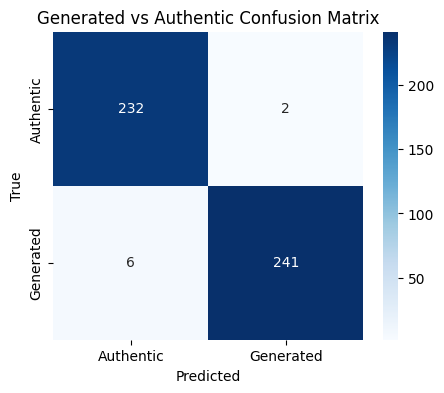

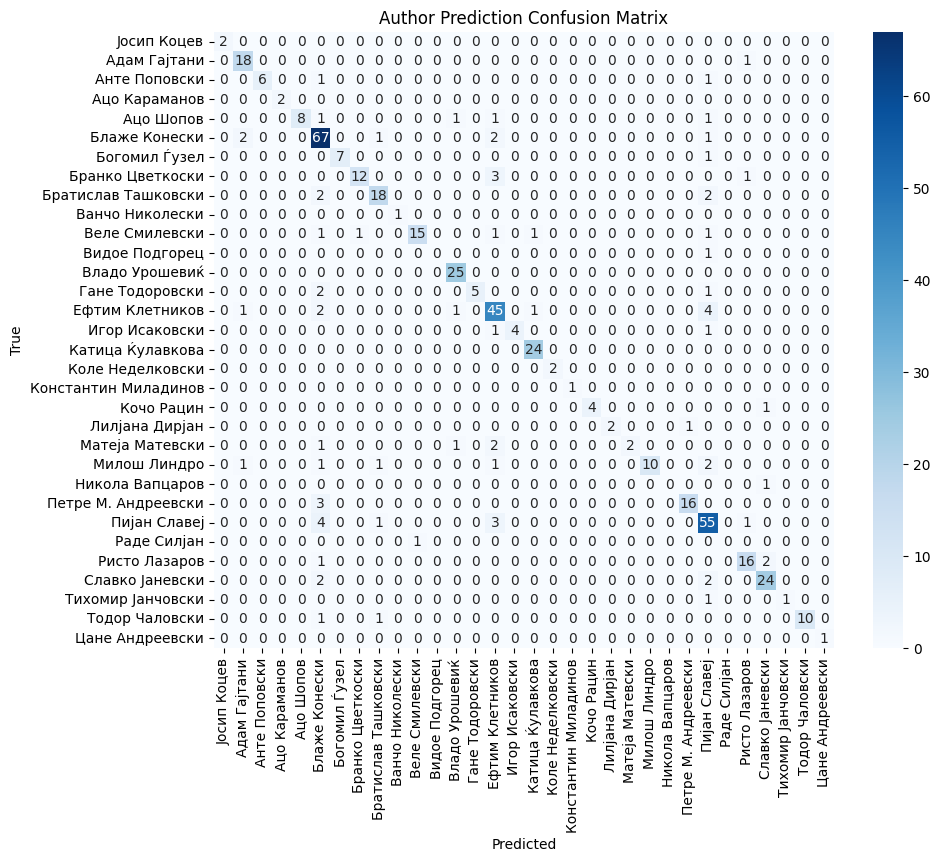

(<Functional name=functional_14, built=True>,
 LabelEncoder(),
 TfidfVectorizer(max_df=0.8904674508605334, max_features=4619, min_df=3))

In [38]:
claude_2='/home/ivan/Desktop/Diplomska/final_results_csv/all_songs_2_claude_idf_styles_with_perplexity.csv'
train_dual_output_model(CSV_PATH,claude_2,min_author_samples=3)

Authentic songs after limiting: 1199
Generated songs after limiting: 1199
Combined dataset size: 2398
Dataset size after filtering authors with <3 samples: 2388
Remaining authors: 32

=== Generated vs Authentic Classification ===
              precision    recall  f1-score   support

   Authentic       0.98      1.00      0.99       226
   Generated       1.00      0.98      0.99       252

    accuracy                           0.99       478
   macro avg       0.99      0.99      0.99       478
weighted avg       0.99      0.99      0.99       478


=== Author Prediction ===
                      precision    recall  f1-score   support

         Јосип Коцев       1.00      1.00      1.00         2
        Адам Гајтани       0.84      0.84      0.84        19
       Анте Поповски       1.00      0.88      0.93         8
       Ацо Караманов       1.00      1.00      1.00         2
           Ацо Шопов       0.91      0.83      0.87        12
       Блаже Конески       0.76      0.93  

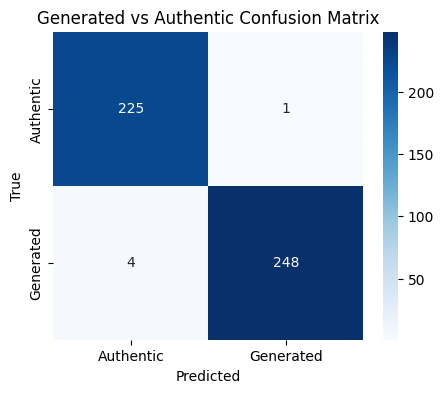

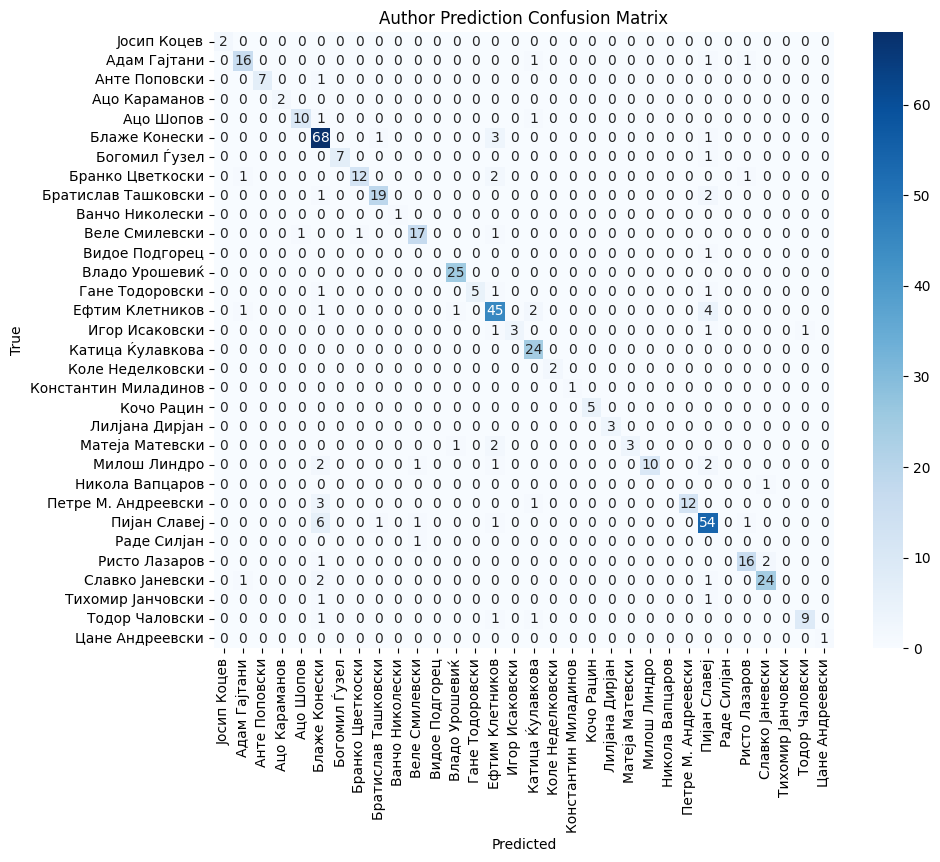

(<Functional name=functional_15, built=True>,
 LabelEncoder(),
 TfidfVectorizer(max_df=0.8904674508605334, max_features=4619, min_df=3))

In [39]:
claude_3='/home/ivan/Desktop/Diplomska/final_results_csv/all_songs_3_claude_idf_with_perplexity.csv'
train_dual_output_model(CSV_PATH,claude_3,min_author_samples=3)

Authentic songs after limiting: 1199
Generated songs after limiting: 1198
Combined dataset size: 2397
Dataset size after filtering authors with <3 samples: 2387
Remaining authors: 32

=== Generated vs Authentic Classification ===
              precision    recall  f1-score   support

   Authentic       0.99      1.00      0.99       227
   Generated       1.00      0.99      0.99       251

    accuracy                           0.99       478
   macro avg       0.99      0.99      0.99       478
weighted avg       0.99      0.99      0.99       478


=== Author Prediction ===
                      precision    recall  f1-score   support

         Јосип Коцев       0.00      0.00      0.00         2
        Адам Гајтани       0.20      0.11      0.14        19
       Анте Поповски       0.50      0.38      0.43         8
       Ацо Караманов       0.00      0.00      0.00         2
           Ацо Шопов       0.40      0.17      0.24        12
       Блаже Конески       0.31      0.47  

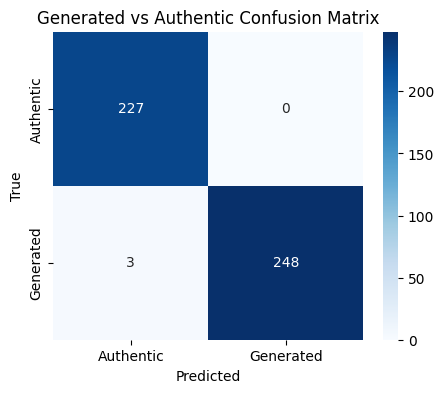

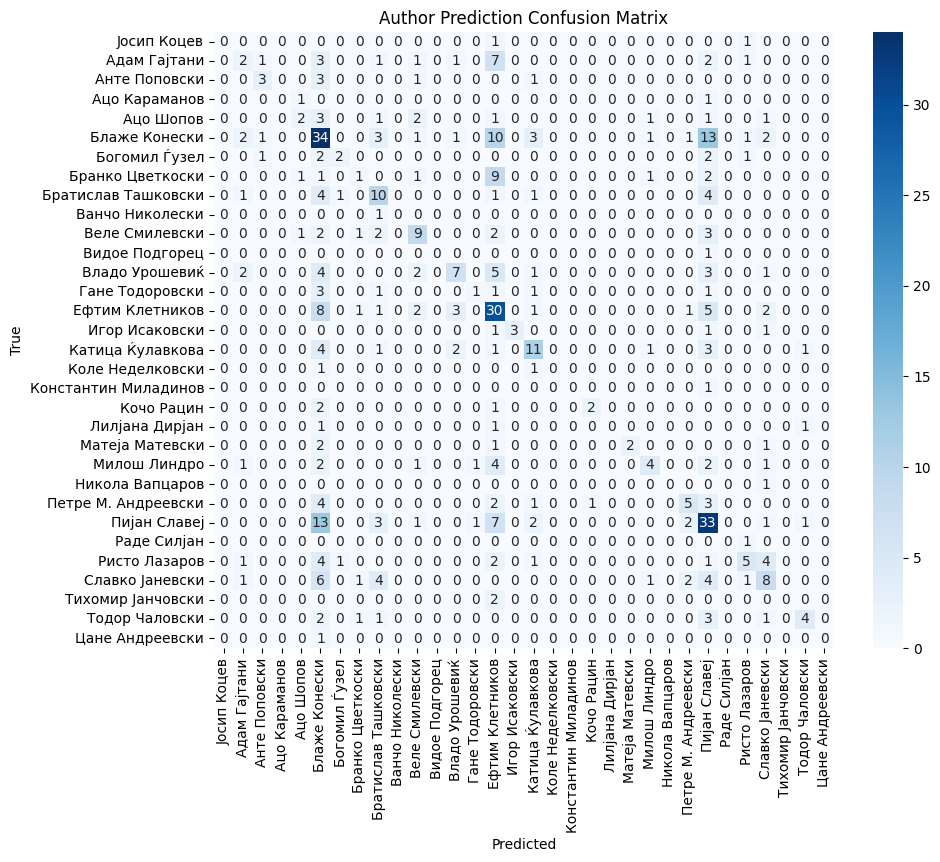

(<Functional name=functional_16, built=True>,
 LabelEncoder(),
 TfidfVectorizer(max_df=0.8904674508605334, max_features=4619, min_df=3))

In [40]:
claude_4='/home/ivan/Desktop/Diplomska/final_results_csv/all_songs_4_claude_styles_with_perplexity.csv'
train_dual_output_model(CSV_PATH,claude_4,min_author_samples=3)

Authentic songs after limiting: 1199
Generated songs after limiting: 1199
Combined dataset size: 2398
Dataset size after filtering authors with <3 samples: 2388
Remaining authors: 32

=== Generated vs Authentic Classification ===
              precision    recall  f1-score   support

   Authentic       0.97      0.99      0.98       226
   Generated       0.99      0.98      0.98       252

    accuracy                           0.98       478
   macro avg       0.98      0.98      0.98       478
weighted avg       0.98      0.98      0.98       478


=== Author Prediction ===
                      precision    recall  f1-score   support

         Јосип Коцев       0.00      0.00      0.00         2
        Адам Гајтани       0.11      0.05      0.07        19
       Анте Поповски       0.75      0.38      0.50         8
       Ацо Караманов       0.00      0.00      0.00         2
           Ацо Шопов       0.17      0.08      0.11        12
       Блаже Конески       0.34      0.58  

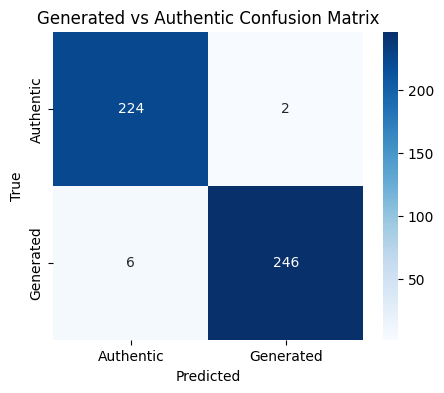

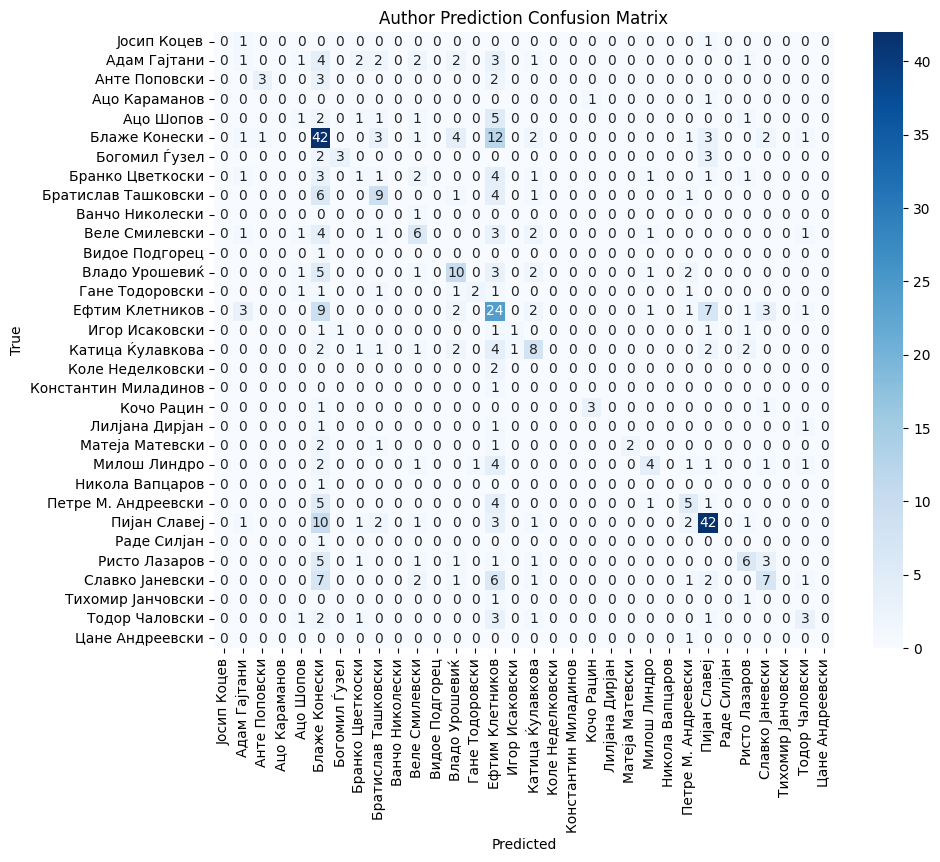

(<Functional name=functional_17, built=True>,
 LabelEncoder(),
 TfidfVectorizer(max_df=0.8904674508605334, max_features=4619, min_df=3))

In [41]:
claude_5='/home/ivan/Desktop/Diplomska/final_results_csv/all_songs_5_claude_raw_author_with_perplexity.csv'
train_dual_output_model(CSV_PATH,claude_5,min_author_samples=3)

Raw author prediction, only on evaluation set. 

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import matplotlib.pyplot as plt
import seaborn as sns

def limit_per_author(df, max_per_author=10):
    return df.groupby("author", group_keys=False).apply(
        lambda x: x.sample(n=min(len(x), max_per_author), random_state=42)
    )

def train_author_model(
    train_csv_path,
    eval_csv_path,
    max_per_author=300,
    min_author_samples=10,
    best_params=None,
    test_size=0.2,
    batch_size=32,
    verbose=0
):
    
    
    if best_params is None:
        best_params = {
            'max_features': 4619,
            'n_layers': 1,
            'neurons': 567,
            'activation': 'tanh',
            'dropout_rate': 0.3406819279083615,
            'optimizer': 'rmsprop',
            'lr': 0.0007878787378953067,
            'l2_reg': 3.145848564707723e-05,
            'n_epochs': 41,
            'min_df': 3,
            'max_df': 0.8904674508605334,
            'ngram_range': (1, 1)
        }

   
    df_authentic = pd.read_csv(train_csv_path)
    df_authentic['song_text'] = df_authentic['song_text'].str.lower()

    df_generated = pd.read_csv(eval_csv_path)
    df_generated['new_song'] = df_generated['new_song'].str.lower()
    df_generated.rename(columns={'new_song': 'song_text'}, inplace=True)

    
    df_authentic_limited = limit_per_author(df_authentic, max_per_author)
    df_generated_limited = limit_per_author(df_generated, max_per_author)

    required_columns = ['song_text', 'author']
    for df, name in [(df_authentic_limited, 'authentic'), (df_generated_limited, 'generated')]:
        missing_cols = [col for col in required_columns if col not in df.columns]
        if missing_cols:
            raise KeyError(f"Missing columns {missing_cols} in {name} DataFrame after limiting")

    print(f"Authentic songs after limiting: {len(df_authentic_limited)}")
    print(f"Generated songs after limiting: {len(df_generated_limited)}")

    df_all = pd.concat([
        df_authentic_limited[required_columns],
        df_generated_limited[required_columns]
    ], ignore_index=True)
    print(f"Combined dataset size: {len(df_all)}")

    author_counts = df_all['author'].value_counts()
    valid_authors = author_counts[author_counts >= min_author_samples].index
    df_all = df_all[df_all['author'].isin(valid_authors)]
    print(f"Dataset size after filtering authors with <{min_author_samples} samples: {len(df_all)}")
    print(f"Remaining authors: {len(valid_authors)}")

    vectorizer = TfidfVectorizer(
        max_features=best_params['max_features'],
        ngram_range=best_params['ngram_range'],
        min_df=best_params['min_df'],
        max_df=best_params['max_df']
    )
    X = vectorizer.fit_transform(df_all['song_text']).toarray()

    
    label_encoder = LabelEncoder()
    y_author = label_encoder.fit_transform(df_all['author'])

    
    X_train, X_test, y_auth_train, y_auth_test = train_test_split(
        X, y_author, test_size=test_size, random_state=42, stratify=y_author
    )

    
    input_layer = layers.Input(shape=(X_train.shape[1],))
    x = input_layer
    for i in range(best_params['n_layers']):
        x = layers.Dense(
            best_params['neurons'],
            activation=best_params['activation'],
            kernel_regularizer=regularizers.l2(best_params['l2_reg'])
        )(x)
        x = layers.Dropout(best_params['dropout_rate'])(x)

    author_output = layers.Dense(len(label_encoder.classes_), activation="softmax", name="author_output")(x)

    model = keras.Model(inputs=input_layer, outputs=author_output)

    optimizer = keras.optimizers.RMSprop(learning_rate=best_params['lr'])
    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    
    history = model.fit(
        X_train,
        y_auth_train,
        validation_split=0.1,
        epochs=best_params['n_epochs'],
        batch_size=batch_size,
        verbose=verbose
    )

    
    y_auth_pred = model.predict(X_test, verbose=0)
    y_auth_pred = np.argmax(y_auth_pred, axis=1)

    print("\n=== Author Prediction ===")
    print(classification_report(y_auth_test, y_auth_pred, target_names=label_encoder.classes_, zero_division=0))

    f1_author = f1_score(y_auth_test, y_auth_pred, average="weighted")
    print(f"\nWeighted F1 - Author: {f1_author:.4f}")

    
    cm_auth = tf.math.confusion_matrix(y_auth_test, y_auth_pred).numpy()
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_auth, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title('Author Prediction Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return model, history, label_encoder, vectorizer

Authentic songs after limiting: 1199
Generated songs after limiting: 1199
Combined dataset size: 2398
Dataset size after filtering authors with <3 samples: 2388
Remaining authors: 32

=== Author Prediction ===
                      precision    recall  f1-score   support

         Јосип Коцев       1.00      0.50      0.67         2
        Адам Гајтани       0.78      0.74      0.76        19
       Анте Поповски       1.00      0.75      0.86         8
       Ацо Караманов       0.00      0.00      0.00         2
           Ацо Шопов       0.89      0.67      0.76        12
       Блаже Конески       0.61      0.89      0.72        73
       Богомил Ѓузел       1.00      0.88      0.93         8
    Бранко Цветкоски       0.92      0.69      0.79        16
 Братислав Ташковски       0.83      0.68      0.75        22
     Ванчо Николески       0.00      0.00      0.00         1
      Веле Смилевски       0.89      0.85      0.87        20
      Видое Подгорец       0.00      0.00    

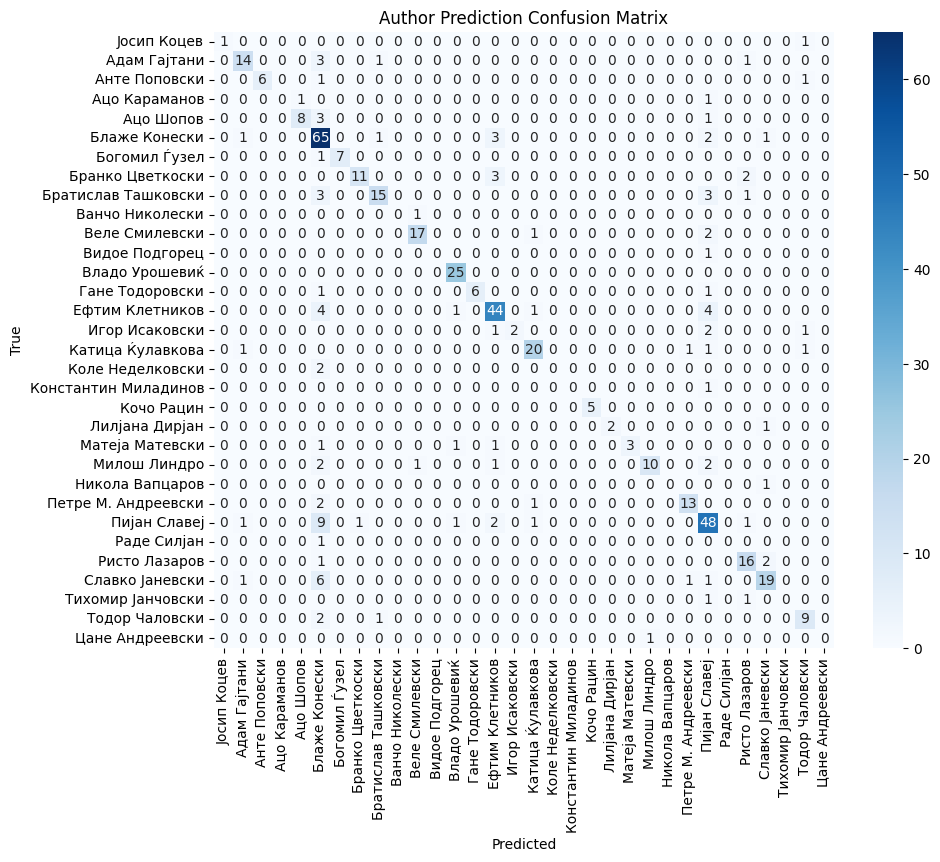

(<Functional name=functional_19, built=True>,
 LabelEncoder(),
 TfidfVectorizer(max_df=0.8904674508605334, max_features=4619, min_df=3))

In [44]:
claude_1='/home/ivan/Desktop/Diplomska/final_results_csv/all_songs_1_claude_example_idf_styles_with_perplexity.csv'
train_author_model(CSV_PATH,claude_1,min_author_samples=3)

Authentic songs after limiting: 1199
Generated songs after limiting: 1212
Combined dataset size: 2411
Dataset size after filtering authors with <3 samples: 2401
Remaining authors: 32

=== Author Prediction ===
                      precision    recall  f1-score   support

         Јосип Коцев       1.00      1.00      1.00         2
        Адам Гајтани       0.71      0.89      0.79        19
       Анте Поповски       1.00      0.75      0.86         8
       Ацо Караманов       1.00      1.00      1.00         2
           Ацо Шопов       1.00      0.67      0.80        12
       Блаже Конески       0.74      0.92      0.82        73
       Богомил Ѓузел       1.00      0.88      0.93         8
    Бранко Цветкоски       0.92      0.75      0.83        16
 Братислав Ташковски       0.78      0.82      0.80        22
     Ванчо Николески       1.00      1.00      1.00         1
      Веле Смилевски       0.88      0.75      0.81        20
      Видое Подгорец       0.00      0.00    

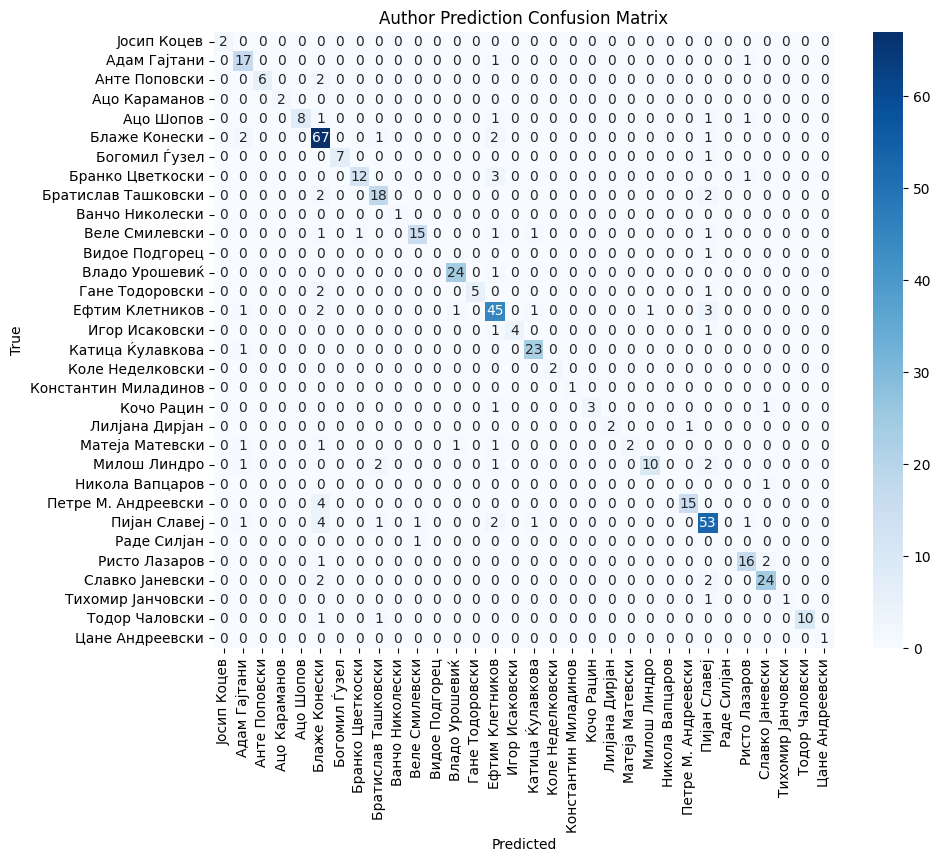

(<Functional name=functional_20, built=True>,
 LabelEncoder(),
 TfidfVectorizer(max_df=0.8904674508605334, max_features=4619, min_df=3))

In [45]:
claude_2='/home/ivan/Desktop/Diplomska/final_results_csv/all_songs_2_claude_idf_styles_with_perplexity.csv'
train_author_model(CSV_PATH,claude_2,min_author_samples=3)

Authentic songs after limiting: 1199
Generated songs after limiting: 1199
Combined dataset size: 2398
Dataset size after filtering authors with <3 samples: 2388
Remaining authors: 32

=== Author Prediction ===
                      precision    recall  f1-score   support

         Јосип Коцев       1.00      1.00      1.00         2
        Адам Гајтани       0.77      0.89      0.83        19
       Анте Поповски       1.00      0.88      0.93         8
       Ацо Караманов       1.00      1.00      1.00         2
           Ацо Шопов       1.00      0.83      0.91        12
       Блаже Конески       0.74      0.92      0.82        73
       Богомил Ѓузел       1.00      1.00      1.00         8
    Бранко Цветкоски       0.92      0.75      0.83        16
 Братислав Ташковски       0.95      0.86      0.90        22
     Ванчо Николески       1.00      1.00      1.00         1
      Веле Смилевски       0.89      0.80      0.84        20
      Видое Подгорец       0.00      0.00    

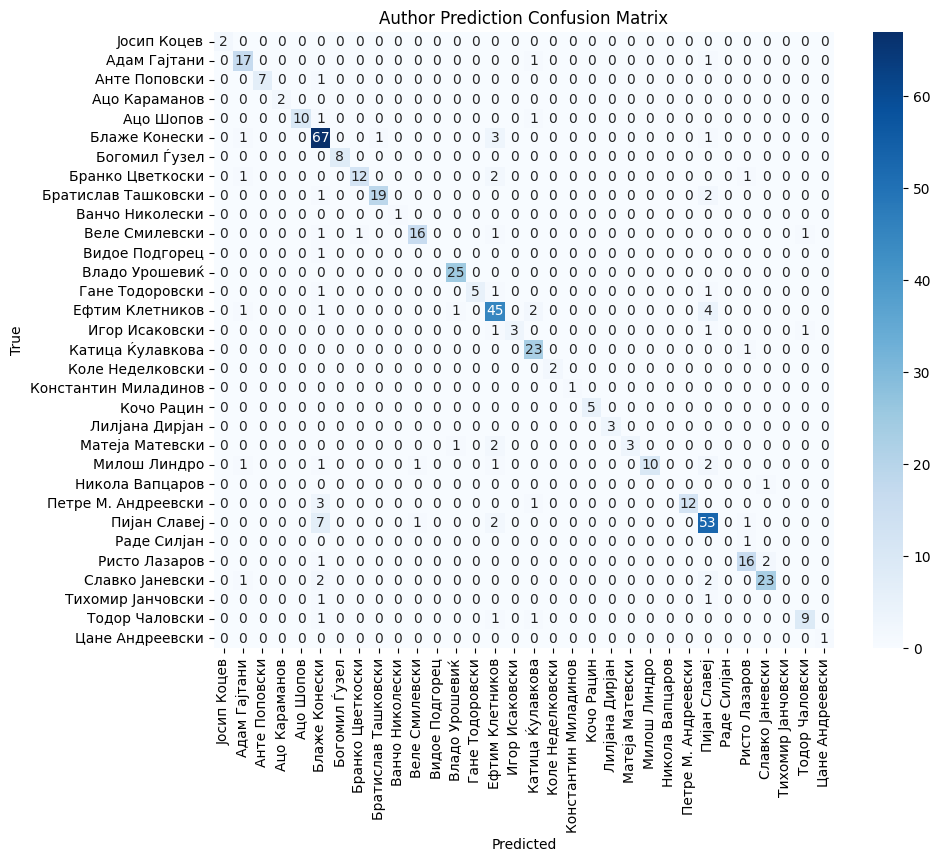

(<Functional name=functional_21, built=True>,
 LabelEncoder(),
 TfidfVectorizer(max_df=0.8904674508605334, max_features=4619, min_df=3))

In [46]:
claude_3='/home/ivan/Desktop/Diplomska/final_results_csv/all_songs_3_claude_idf_with_perplexity.csv'
train_author_model(CSV_PATH,claude_3,min_author_samples=3)

Authentic songs after limiting: 1199
Generated songs after limiting: 1198
Combined dataset size: 2397
Dataset size after filtering authors with <3 samples: 2387
Remaining authors: 32

=== Author Prediction ===
                      precision    recall  f1-score   support

         Јосип Коцев       0.00      0.00      0.00         2
        Адам Гајтани       0.20      0.11      0.14        19
       Анте Поповски       0.60      0.38      0.46         8
       Ацо Караманов       0.00      0.00      0.00         2
           Ацо Шопов       0.33      0.17      0.22        12
       Блаже Конески       0.34      0.48      0.40        73
       Богомил Ѓузел       0.50      0.25      0.33         8
    Бранко Цветкоски       0.20      0.06      0.10        16
 Братислав Ташковски       0.37      0.50      0.42        22
     Ванчо Николески       0.00      0.00      0.00         1
      Веле Смилевски       0.33      0.45      0.38        20
      Видое Подгорец       0.00      0.00    

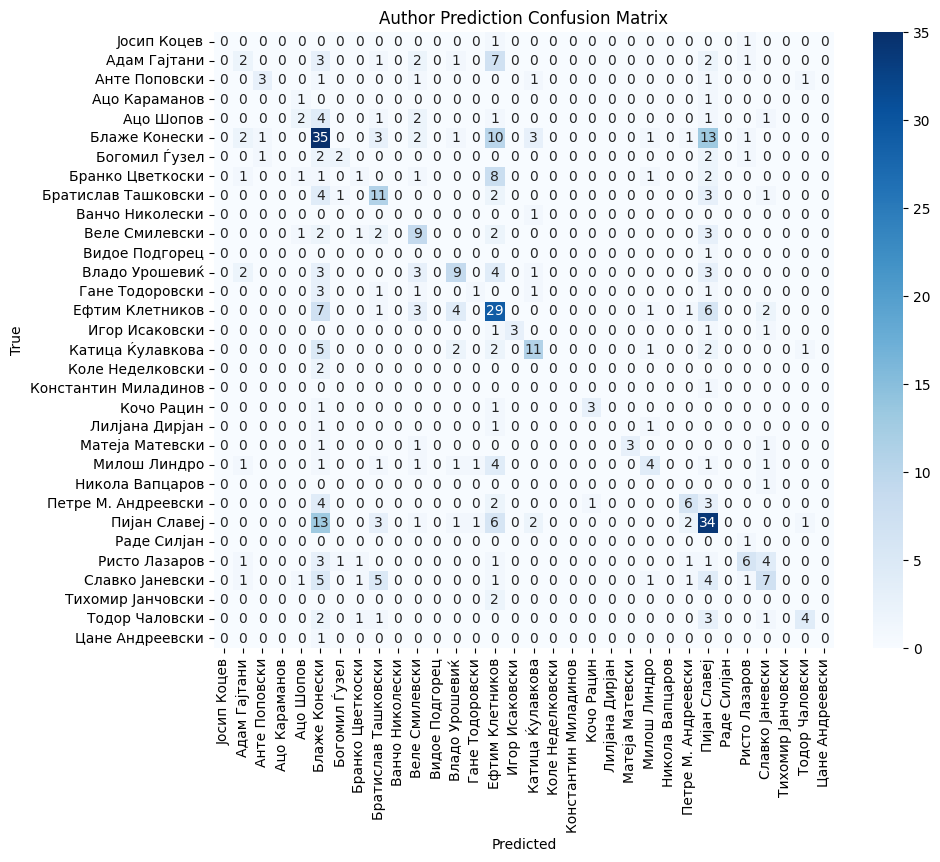

(<Functional name=functional_22, built=True>,
 LabelEncoder(),
 TfidfVectorizer(max_df=0.8904674508605334, max_features=4619, min_df=3))

In [47]:
claude_4='/home/ivan/Desktop/Diplomska/final_results_csv/all_songs_4_claude_styles_with_perplexity.csv'
train_author_model(CSV_PATH,claude_4,min_author_samples=3)

Authentic songs after limiting: 1199
Generated songs after limiting: 1199
Combined dataset size: 2398
Dataset size after filtering authors with <3 samples: 2388
Remaining authors: 32

=== Author Prediction ===
                      precision    recall  f1-score   support

         Јосип Коцев       0.00      0.00      0.00         2
        Адам Гајтани       0.12      0.05      0.07        19
       Анте Поповски       0.75      0.38      0.50         8
       Ацо Караманов       0.00      0.00      0.00         2
           Ацо Шопов       0.17      0.08      0.11        12
       Блаже Конески       0.36      0.58      0.44        73
       Богомил Ѓузел       1.00      0.38      0.55         8
    Бранко Цветкоски       0.11      0.06      0.08        16
 Братислав Ташковски       0.39      0.41      0.40        22
     Ванчо Николески       0.00      0.00      0.00         1
      Веле Смилевски       0.32      0.35      0.33        20
      Видое Подгорец       0.00      0.00    

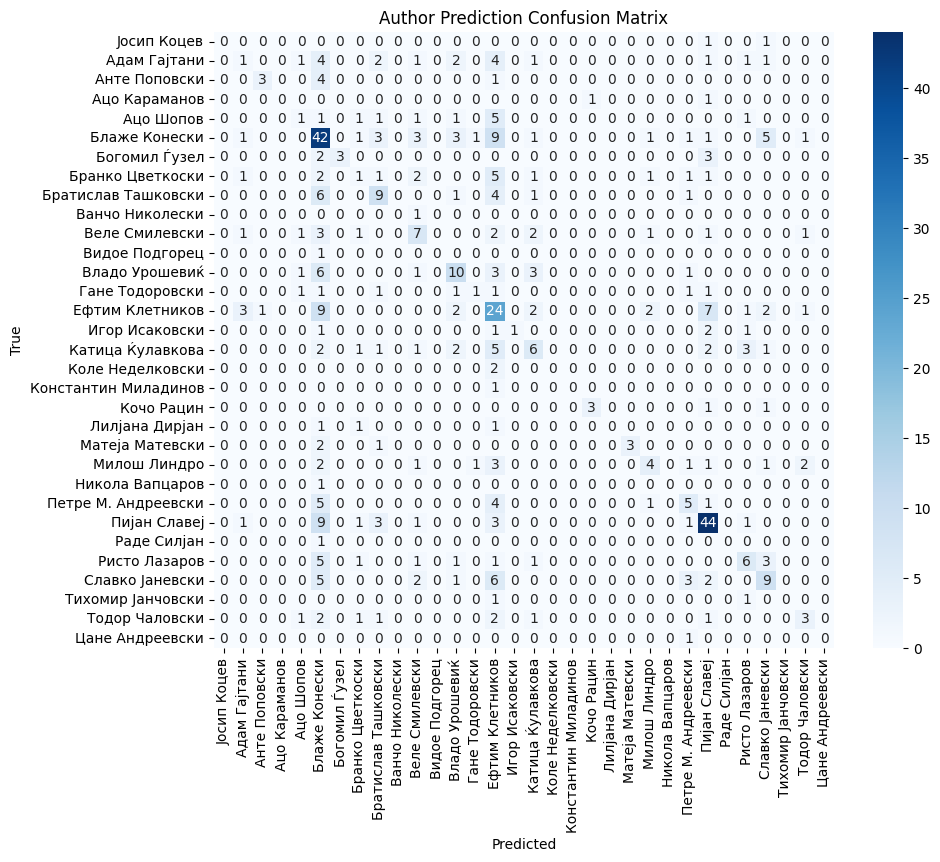

(<Functional name=functional_18, built=True>,
 LabelEncoder(),
 TfidfVectorizer(max_df=0.8904674508605334, max_features=4619, min_df=3))

In [43]:
claude_5='/home/ivan/Desktop/Diplomska/final_results_csv/all_songs_5_claude_raw_author_with_perplexity.csv'
train_author_model(CSV_PATH,claude_5,min_author_samples=3)

Perplexity test

Best kde for Perplexity


Running with method: wasserstein
Target file: cleaned_songs_with_perplexity.csv

WASSERSTEIN distances to target (sorted from closest to farthest):
all_songs_5_nova_raw_author_with_perplexity.csv: 0.0018
all_songs_3_claude_idf_with_perplexity.csv: 0.0031
all_songs_4_claude_styles_with_perplexity.csv: 0.0032
all_songs_2_claude_idf_styles_with_perplexity.csv: 0.0033
all_songs_1_claude_example_idf_styles_with_perplexity.csv: 0.0033
all_songs_5_claude_raw_author_with_perplexity.csv: 0.0037

Closest file: all_songs_5_nova_raw_author_with_perplexity.csv (Distance: 0.0018)


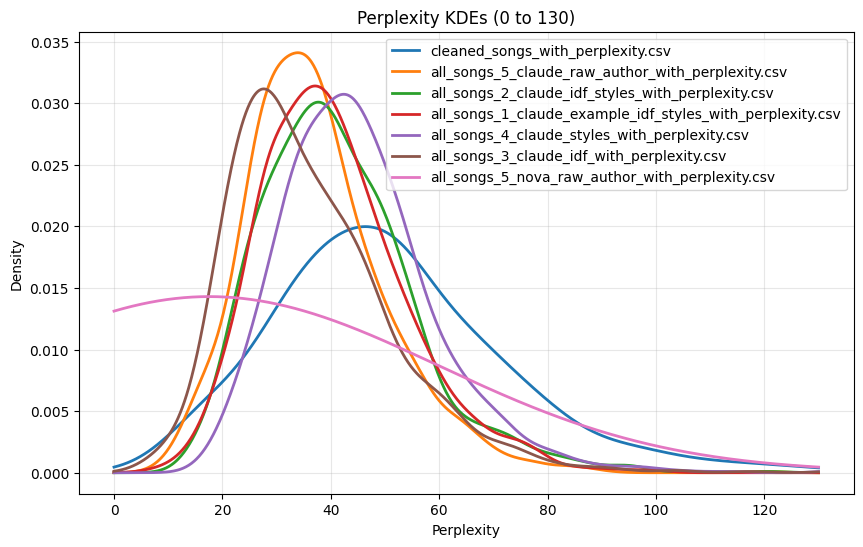


Running with method: ise
Target file: cleaned_songs_with_perplexity.csv

ISE distances to target (sorted from closest to farthest):
all_songs_5_nova_raw_author_with_perplexity.csv: 0.0000
all_songs_2_claude_idf_styles_with_perplexity.csv: 0.0001
all_songs_4_claude_styles_with_perplexity.csv: 0.0001
all_songs_3_claude_idf_with_perplexity.csv: 0.0001
all_songs_1_claude_example_idf_styles_with_perplexity.csv: 0.0001
all_songs_5_claude_raw_author_with_perplexity.csv: 0.0001

Closest file: all_songs_5_nova_raw_author_with_perplexity.csv (Distance: 0.0000)


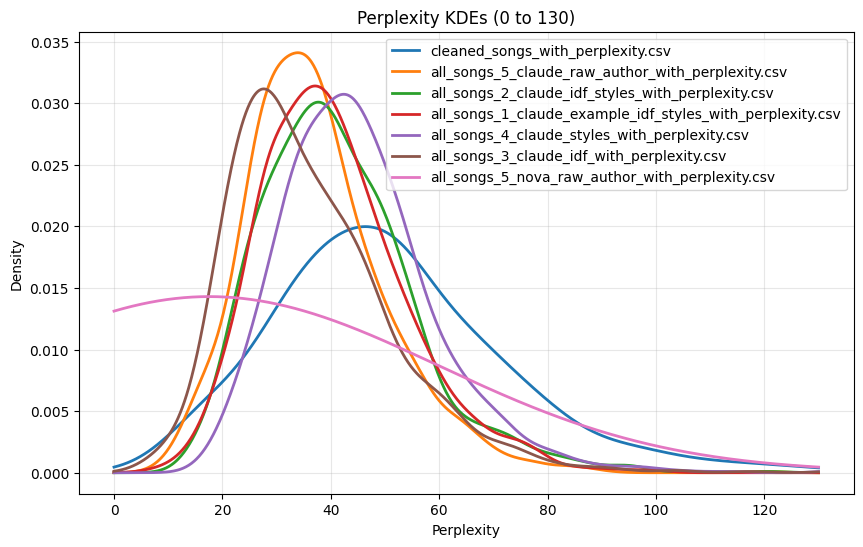


Running with method: kl
Target file: cleaned_songs_with_perplexity.csv

KL distances to target (sorted from closest to farthest):
all_songs_5_nova_raw_author_with_perplexity.csv: 0.2090
all_songs_4_claude_styles_with_perplexity.csv: 0.2846
all_songs_2_claude_idf_styles_with_perplexity.csv: 0.2879
all_songs_3_claude_idf_with_perplexity.csv: 0.3805
all_songs_1_claude_example_idf_styles_with_perplexity.csv: 0.4673
all_songs_5_claude_raw_author_with_perplexity.csv: 0.6055

Closest file: all_songs_5_nova_raw_author_with_perplexity.csv (Distance: 0.2090)


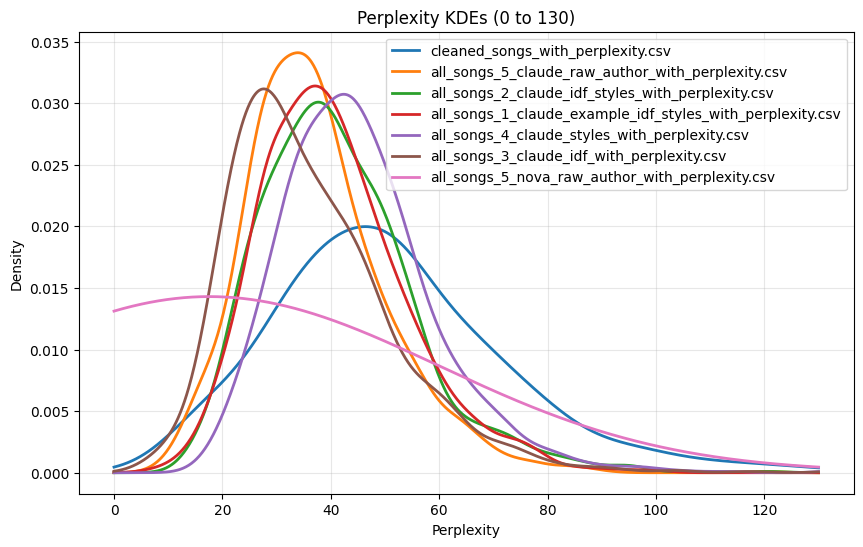


Running with method: hellinger
Target file: cleaned_songs_with_perplexity.csv

HELLINGER distances to target (sorted from closest to farthest):
all_songs_4_claude_styles_with_perplexity.csv: 0.0186
all_songs_2_claude_idf_styles_with_perplexity.csv: 0.0195
all_songs_5_nova_raw_author_with_perplexity.csv: 0.0208
all_songs_1_claude_example_idf_styles_with_perplexity.csv: 0.0209
all_songs_3_claude_idf_with_perplexity.csv: 0.0228
all_songs_5_claude_raw_author_with_perplexity.csv: 0.0259

Closest file: all_songs_4_claude_styles_with_perplexity.csv (Distance: 0.0186)


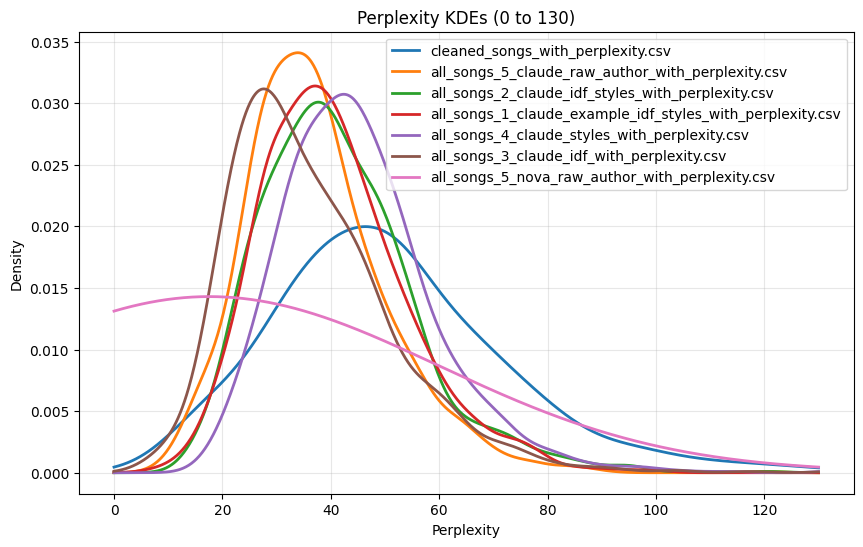


Running with method: skew_adjusted_wasserstein
Target file: cleaned_songs_with_perplexity.csv

SKEW_ADJUSTED_WASSERSTEIN distances to target (sorted from closest to farthest):
all_songs_3_claude_idf_with_perplexity.csv: 0.1232
all_songs_4_claude_styles_with_perplexity.csv: 0.1276
all_songs_2_claude_idf_styles_with_perplexity.csv: 0.1443
all_songs_5_claude_raw_author_with_perplexity.csv: 0.1536
all_songs_1_claude_example_idf_styles_with_perplexity.csv: 0.1684
all_songs_5_nova_raw_author_with_perplexity.csv: 0.2031

Closest file: all_songs_3_claude_idf_with_perplexity.csv (Distance: 0.1232)


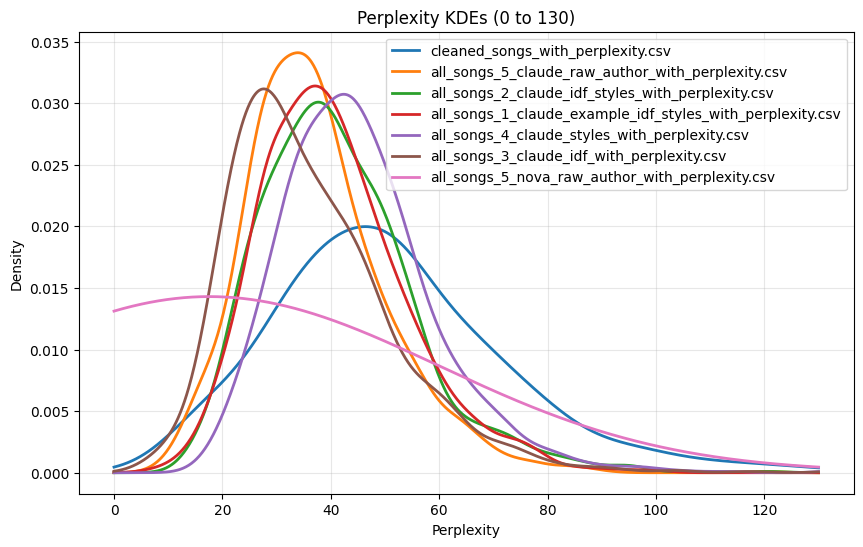

In [ ]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, wasserstein_distance, skew, entropy
from scipy.signal import find_peaks
from scipy.integrate import simpson

def compare_perplexity_kde(folder_path="/home/ivan/Desktop/Diplomska/final_results_csv", target_file='cleaned_songs_with_perplexity.csv', method="ise", weight_sigma=10):
    
    if not os.path.exists(folder_path):
        print(f"Error: Folder '{folder_path}' does not exist.")
        return
    
   
    csv_files = glob.glob(os.path.join(folder_path, "*perplexity*.csv"))
    if not csv_files:
        print(f"No CSV files with 'perplexity' found in '{folder_path}'.")
        print("Available files:", os.listdir(folder_path))
        return
    
   
    target_file_full = os.path.join(folder_path, target_file)
    if os.path.basename(target_file_full) not in [os.path.basename(f) for f in csv_files]:
        print(f"Target file '{target_file}' not found in '{folder_path}'.")
        print("Available files:", [os.path.basename(f) for f in csv_files])
        return
    
   
    grid = np.linspace(0, 130, 1000)  
    delta_x = grid[1] - grid[0]  
    try:
        target_df = pd.read_csv(target_file_full)
    except Exception as e:
        print(f"Error reading target file '{target_file}': {e}")
        return
    perplexity_col = next((col for col in target_df.columns if 'perplexity' in col.lower()), None)
    if perplexity_col is None:
        print(f"No 'perplexity' column found in target file '{target_file}'.")
        print("Available columns:", target_df.columns.tolist())
        return
    target_data = target_df[perplexity_col].dropna()
    if len(target_data) == 0:
        print(f"No valid perplexity data in target file '{target_file}'.")
        return
    target_kde = gaussian_kde(target_data)
    target_kde_vals = target_kde(grid)
    target_kde_vals /= np.sum(target_kde_vals) * delta_x  
    
    
    peak_idx, _ = find_peaks(target_kde_vals)
    peak_x = grid[peak_idx[0]]  
    weights = np.exp(-((grid - peak_x)**2) / (2 * weight_sigma**2))  
    weights /= np.sum(weights) * delta_x  
    target_skew = skew(target_data)
    
    
    distances = []
    valid_files = []
    kde_vals_list = [(os.path.basename(target_file), target_kde_vals)]
    
    
    for file in csv_files:
        if file == target_file_full:
            continue
        try:
            df = pd.read_csv(file)
        except Exception as e:
            print(f"Error reading file '{os.path.basename(file)}': {e}")
            continue
        perplexity_col = next((col for col in df.columns if 'perplexity' in col.lower()), None)
        if perplexity_col is None:
            print(f"Skipping '{os.path.basename(file)}' — no 'perplexity' column found.")
            print("Available columns:", df.columns.tolist())
            continue
        data = df[perplexity_col].dropna()
        if len(data) == 0:
            print(f"Skipping '{os.path.basename(file)}' — no valid perplexity data.")
            continue
        
       
        kde = gaussian_kde(data)
        kde_vals = kde(grid)
        kde_vals /= np.sum(kde_vals) * delta_x 
        
        
        if method.lower() == "wasserstein":
            dist = wasserstein_distance(target_kde_vals, kde_vals)  
        elif method.lower() == "ise":
            dist = simpson((target_kde_vals - kde_vals)**2 * weights, grid)
        elif method.lower() == "kl":
            p = target_kde_vals + 1e-10
            q = kde_vals + 1e-10
            dist = entropy(p, q)  
        elif method.lower() == "hellinger":
            p = np.sqrt(target_kde_vals + 1e-10)
            q = np.sqrt(kde_vals + 1e-10)
            dist = np.sqrt(simpson((p - q)**2 * weights, grid)) / np.sqrt(2)
        elif method.lower() == "skew_adjusted_wasserstein":
            w_dist = wasserstein_distance(target_kde_vals, kde_vals)
            candidate_skew = skew(data)
            dist = w_dist + 0.1 * abs(target_skew - candidate_skew)
        else:
            print(f"Unknown method '{method}'. Using ISE as default.")
            dist = simpson((target_kde_vals - kde_vals)**2 * weights, grid)
        
        distances.append(dist)
        valid_files.append(os.path.basename(file))
        kde_vals_list.append((os.path.basename(file), kde_vals))
    
    if not valid_files:
        print("No valid candidate files with perplexity data found.")
        return
    
   
    sorted_distances = sorted(zip(distances, valid_files), key=lambda x: x[0])
    
    
    closest_file = sorted_distances[0][1]
    closest_dist = sorted_distances[0][0]
    
    
    print(f"Target file: {os.path.basename(target_file)}")
    print(f"\n{method.upper()} distances to target (sorted from closest to farthest):")
    for dist, file in sorted_distances:
        print(f"{file}: {dist:.4f}")
    print(f"\nClosest file: {closest_file} (Distance: {closest_dist:.4f})")
    
    
    plt.figure(figsize=(10, 6))
    for file_name, kde_vals in kde_vals_list:
        plt.plot(grid, kde_vals, label=file_name, linewidth=2)
    plt.title("Perplexity KDEs (0 to 130)")
    plt.xlabel("Perplexity")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


methods = ["wasserstein", "ise", "kl", "hellinger", "skew_adjusted_wasserstein"]
for m in methods:
        print(f"\nRunning with method: {m}")
        compare_perplexity_kde(method=m)